In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
cifar_train_set = datasets.CIFAR10('./data/cifar10/', train = True, download = True)
cifar_test_set = datasets.CIFAR10('./data/cifar10/', train = False, download = True)

train_input = torch.from_numpy(cifar_train_set.data)
train_input = train_input.transpose(3, 1).transpose(2, 3).float().to(device)

test_input = torch.from_numpy(cifar_test_set.data).float()
test_input = test_input.transpose(3, 1).transpose(2, 3).float().to(device)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_input.shape

torch.Size([50000, 3, 32, 32])

In [5]:
test_input.shape

torch.Size([10000, 3, 32, 32])

In [6]:
def train_model(model,
                optimizer,
                criterion,
                train_input,
                lr=0.005,
                batch_size=50,
                nb_epoch=8,
                weight_decay=0):
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)

    for e in range(nb_epoch):
        print(e)
        index_train_dl = DataLoader(range(len(train_input)),
                                    batch_size=batch_size,
                                    shuffle=True)
        for i, batch_indices in enumerate(index_train_dl):
            input_ = train_input[batch_indices]
            output = model(input_)
            loss = criterion(output, input_)
            if i % 10 == 0:
                print(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [7]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 8, 4, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.convt = nn.ConvTranspose2d(32, 32, 17, stride=1)
        self.relu4 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 3, 1, stride=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.relu1(x)
        #print(x.shape)
        x = self.bn1(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.relu2(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = self.relu3(x)
        #print(x.shape)
        x = self.bn2(x)
        #print("Before conv transpose")
        #print(x.shape)
        #print("After conv transpose")
        x = self.convt(x)
        #print(x.shape)
        #x = self.conv4(x)
        #print(x.shape)
        x = self.relu4(x)
        #print(x.shape)
        x = self.bn3(x)
        #print(x.shape)
        x = self.conv5(x)
        #print(x.shape)
        x = self.sigmoid(x)
        #print(x.shape)
        return x

In [9]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=2), # 32x32x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 5, stride=1, padding=2), # 32x32x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),                           # 32x16x16
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # 64x16x16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),                           # 64x8x8
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 128x8x8
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1), # 128x8x8
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1), # 64x10x10
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1), # 64x12x12
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1), # 64x14x14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1), # 64x16x16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, 5, stride=1), # 3x20x20
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 5, stride=1), # 3x24x24
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 5, stride=1), # 3x28x28
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 5, stride=1), # 3x32x32
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        print(x.shape)
        return x

In [10]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 4, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 8, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 4, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 5, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        return x

In [11]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 4, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [43]:
class Model6(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 2, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 2, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 4, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [52]:
class Model7(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 2, stride=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [88]:
class Model8(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 16, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 16, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 4, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [90]:
model = Model8().to(device)
loss = nn.MSELoss().to(device)

train_model(model, torch.optim.Adam, loss, train_input, batch_size=150, lr=0.1)

0
tensor(17421.8242, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(4970.0942, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(4511.9341, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(4015.8237, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3598.7051, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3406.9092, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3669.6956, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3763.5383, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3255.6594, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3253.4668, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3457.0605, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3056.8535, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3011.0200, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2876.6467, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3282.9995, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(3395.6868, device='cuda:0', grad_fn=<MseLossBackward>)
tenso

In [68]:
model = Model3().to(device)
loss = nn.MSELoss().to(device)

train_model(model, torch.optim.Adam, loss, train_input, batch_size=200)

0
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
tensor(18422.2598, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
tensor(18645.4062, device='cuda:0', grad_fn=<MseLossBackward>)
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
torch.Size([200, 128, 8, 8])
torch.Size([200, 3, 32, 32])
to

KeyboardInterrupt: 

In [152]:
model = Model2().to(device)
loss = nn.MSELoss().to(device)

train_model(model, torch.optim.Adam, loss, train_input, batch_size=200)

0
tensor(18869.2305, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18085.1797, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(19030.6465, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18233.3711, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(17965.3906, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18040.3770, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18900.4258, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(17640.1777, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18085.8809, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18178.3066, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(19216.2383, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18713.5195, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(17457.0742, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18408.8281, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18482.3145, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18177.6328, device='cuda:0', grad_fn=<MseLossB

KeyboardInterrupt: 

In [102]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

In [95]:
pytorch_total_params

107427

In [96]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [97]:
get_n_params(model)

107427

In [107]:
model = Model1().to(device)
loss = nn.MSELoss().to(device)

train_model(model, torch.optim.Adam, loss, train_input, batch_size=200)

0
tensor(19427.8379, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(14759.7754, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1498226.7500, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(11642.5020, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(17743.4824, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(19084.5039, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18180.1602, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18160.9277, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18671.7012, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18777.1699, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18497.4219, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18972.1562, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18615.6328, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18320.9980, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(19132.9238, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(18714.9629, device='cuda:0', grad_fn=<MseLos

KeyboardInterrupt: 

In [91]:
compressed = model(test_input[:100])

In [92]:
import matplotlib.pyplot as plt
import numpy as np

In [93]:
def imshow(img):
    npimg = img.numpy() / 255.0
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

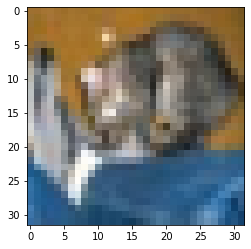

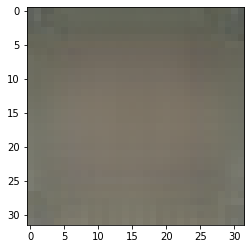

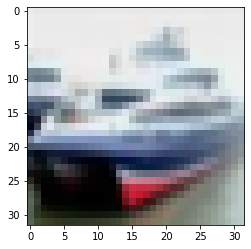

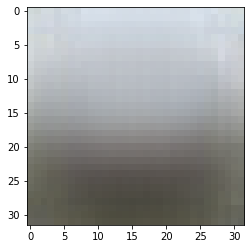

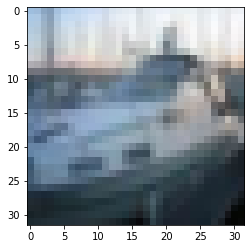

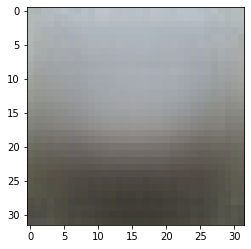

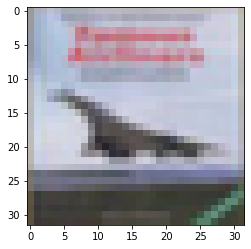

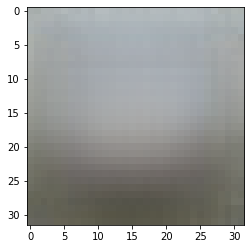

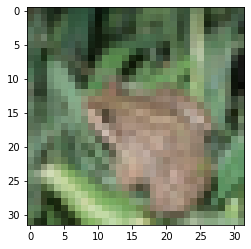

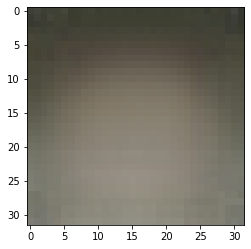

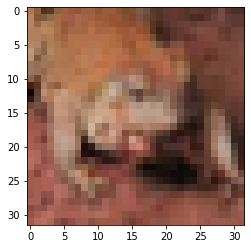

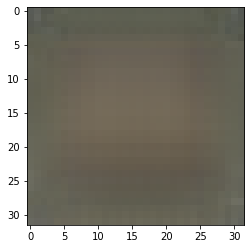

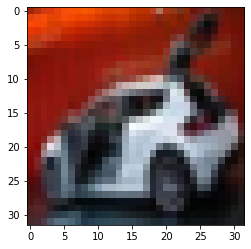

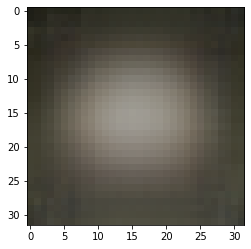

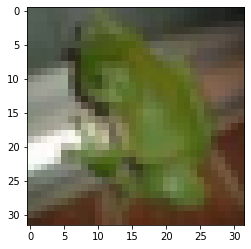

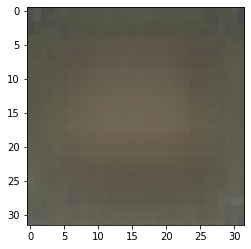

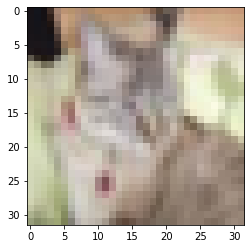

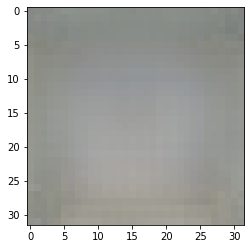

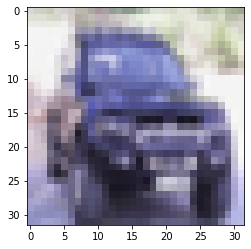

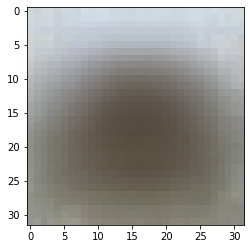

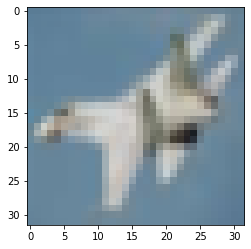

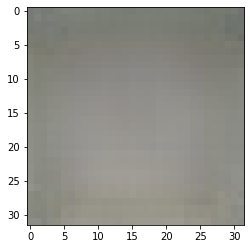

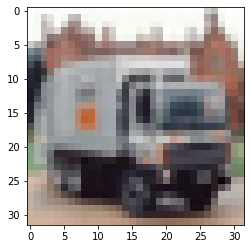

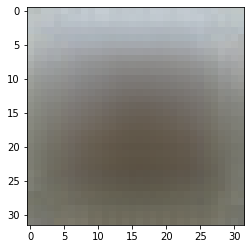

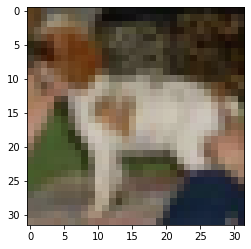

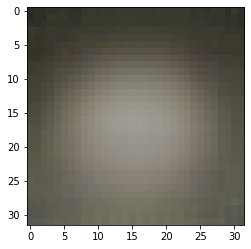

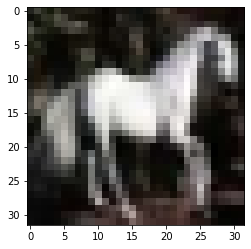

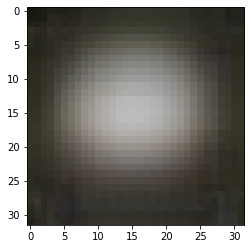

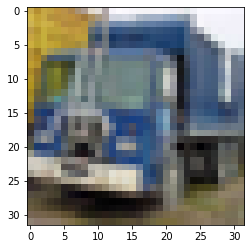

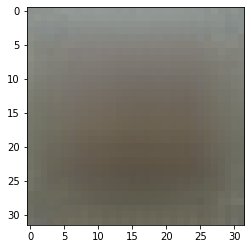

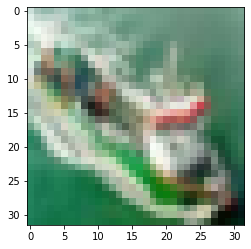

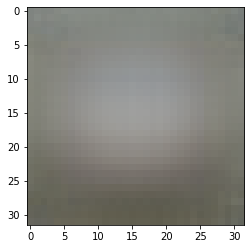

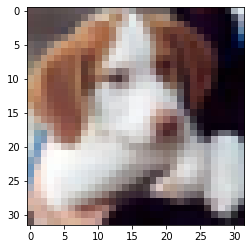

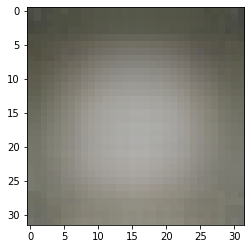

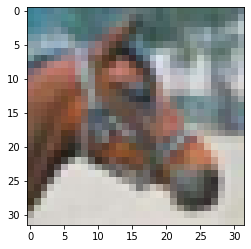

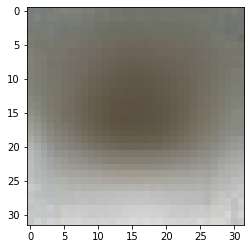

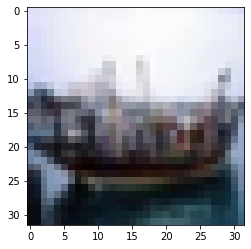

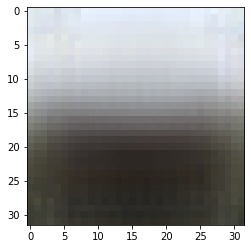

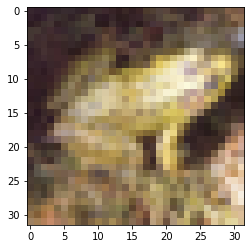

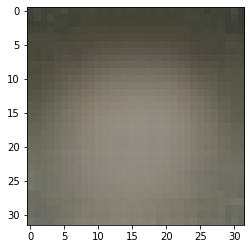

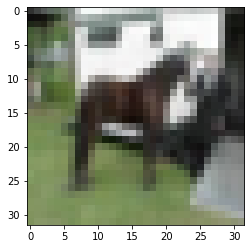

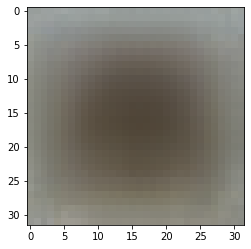

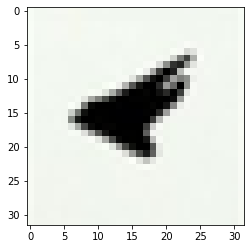

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


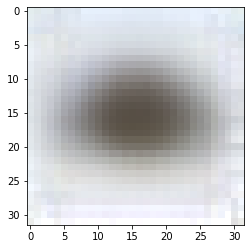

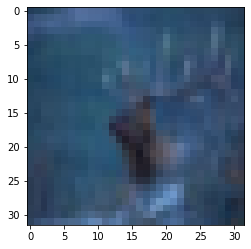

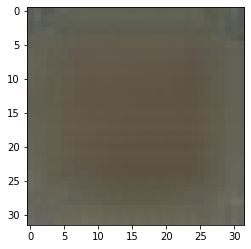

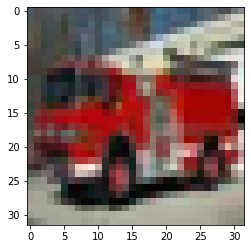

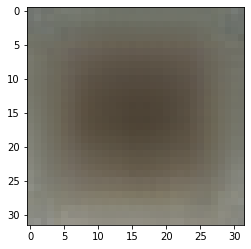

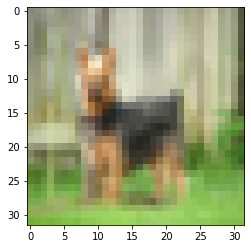

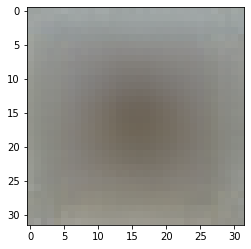

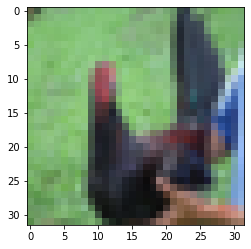

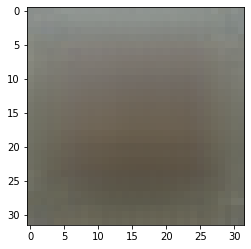

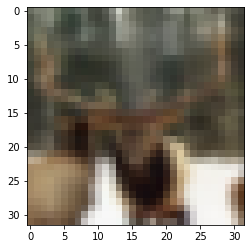

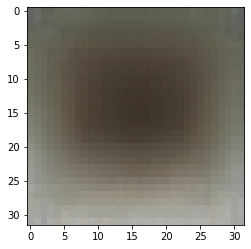

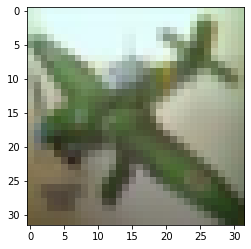

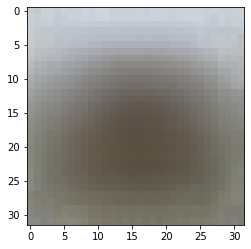

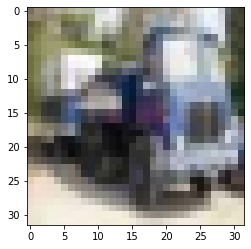

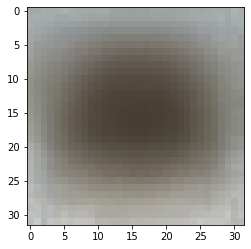

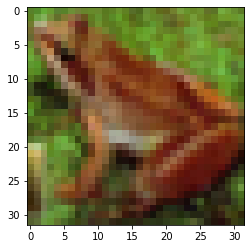

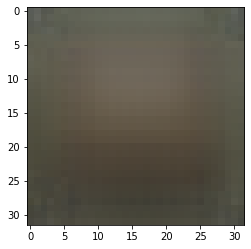

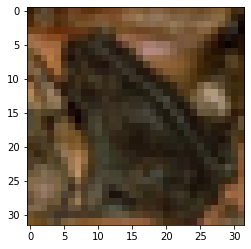

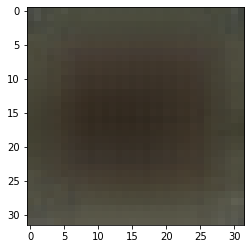

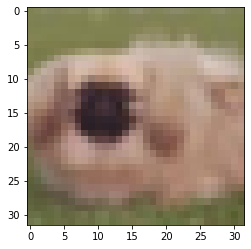

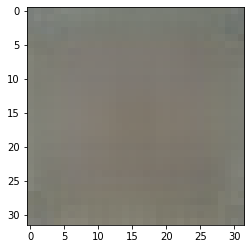

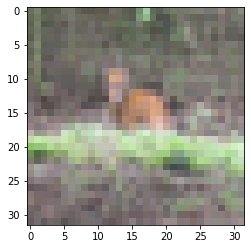

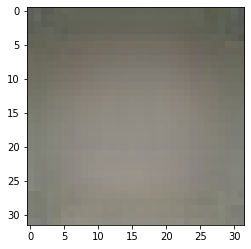

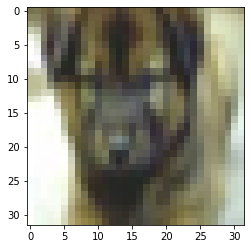

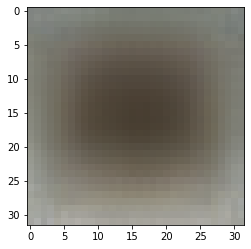

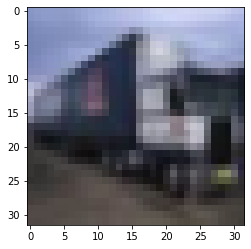

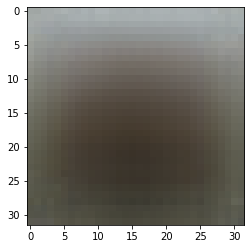

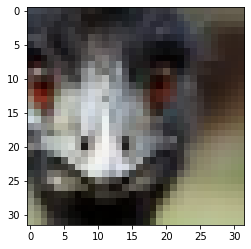

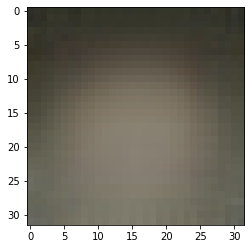

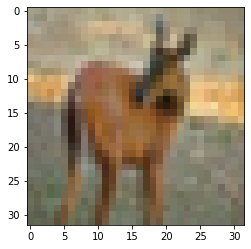

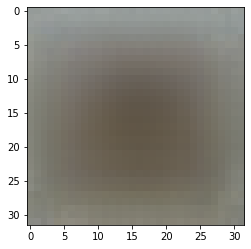

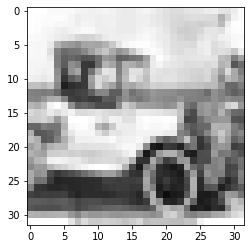

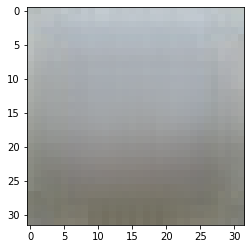

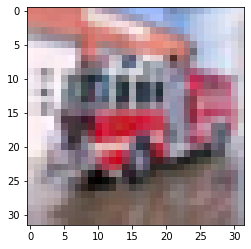

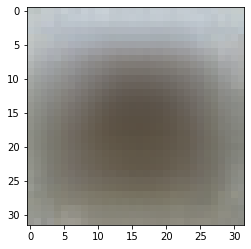

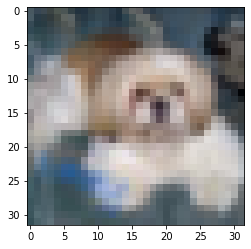

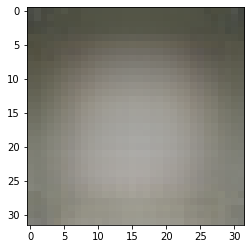

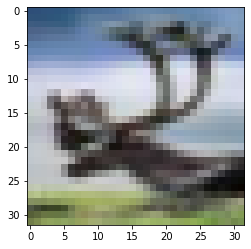

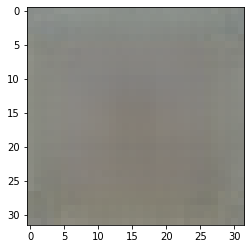

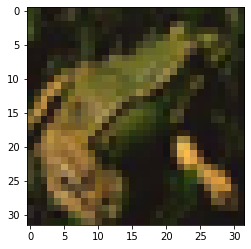

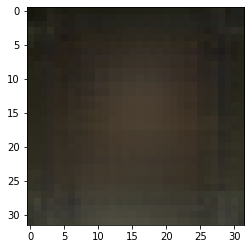

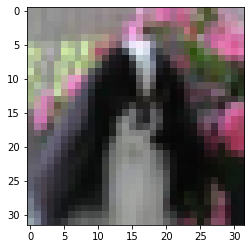

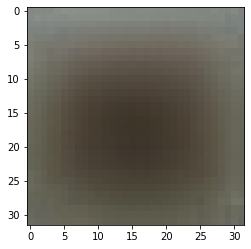

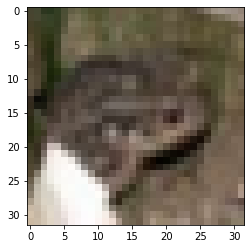

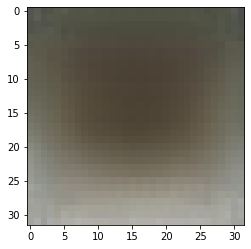

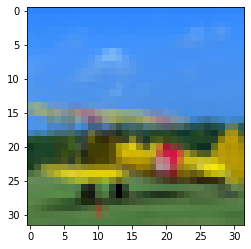

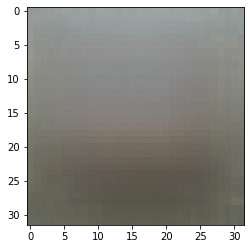

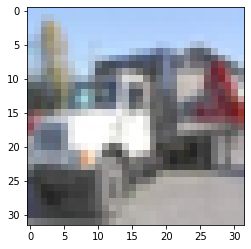

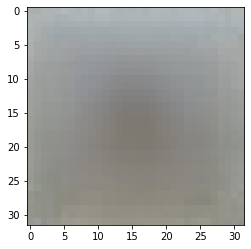

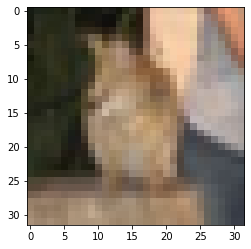

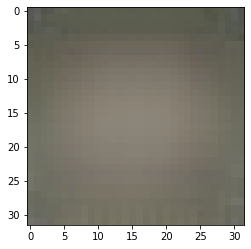

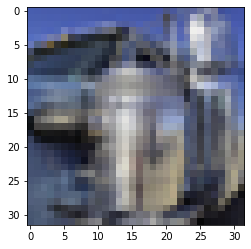

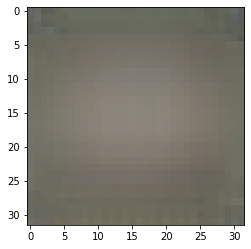

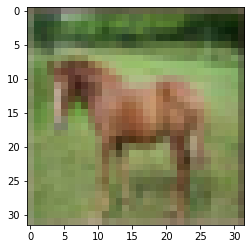

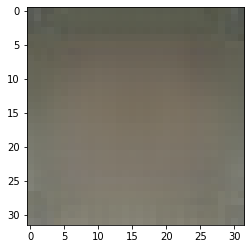

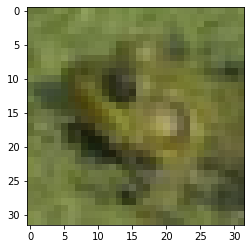

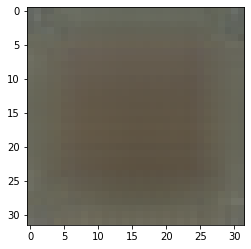

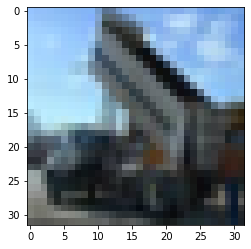

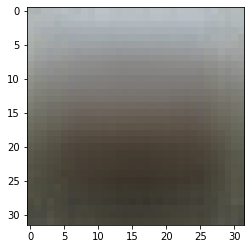

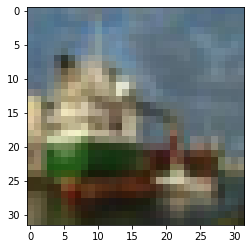

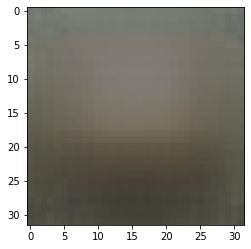

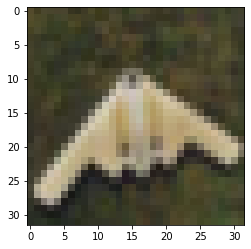

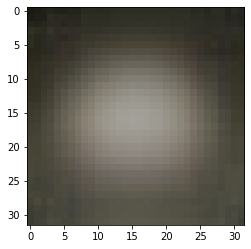

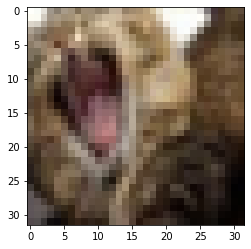

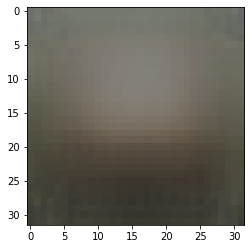

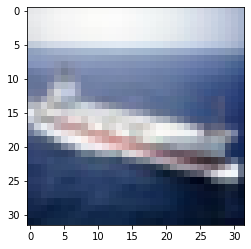

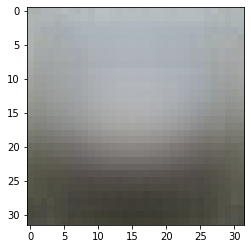

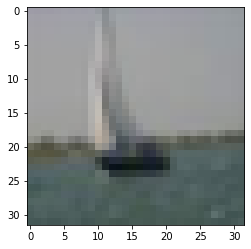

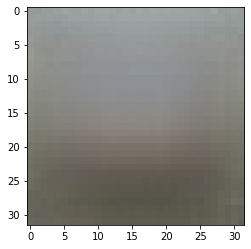

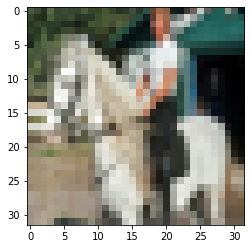

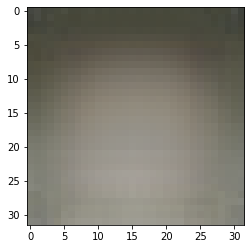

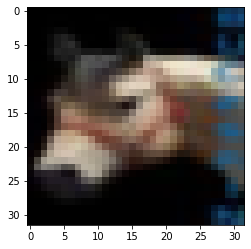

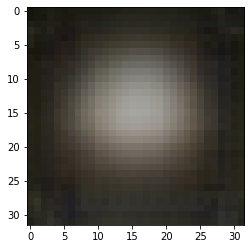

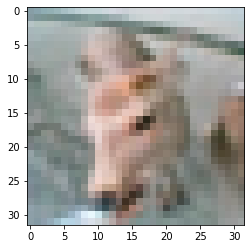

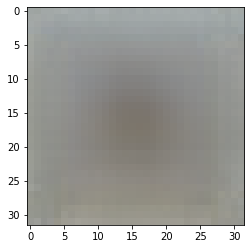

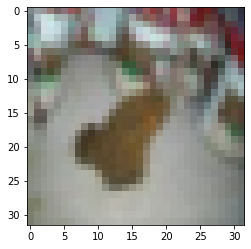

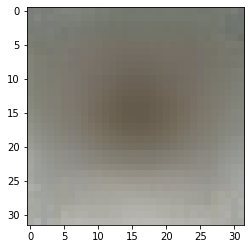

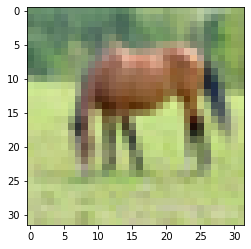

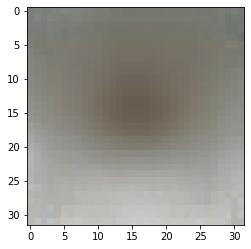

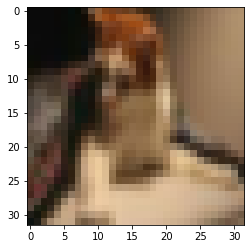

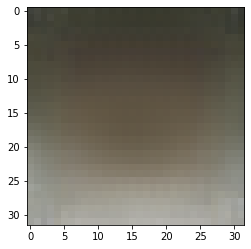

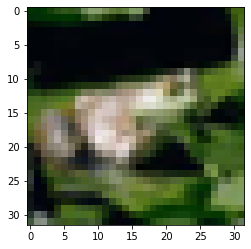

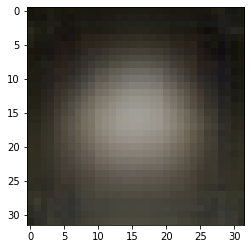

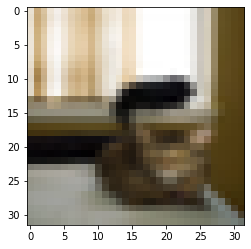

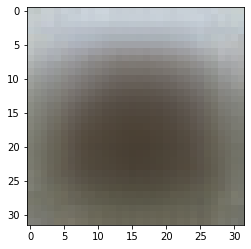

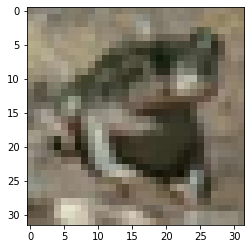

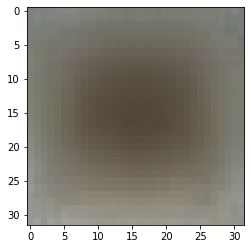

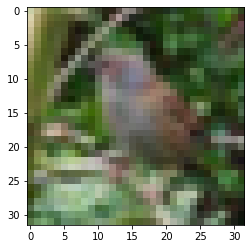

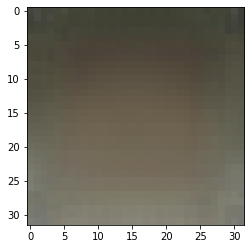

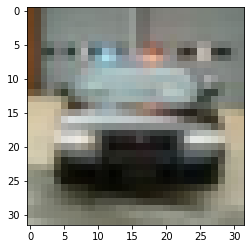

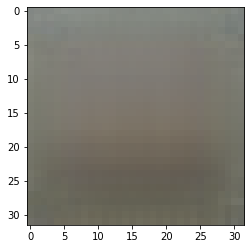

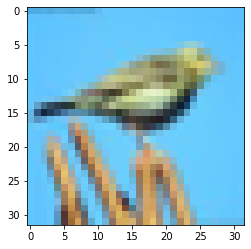

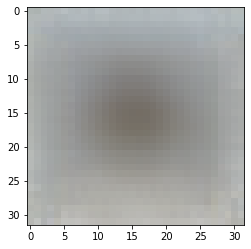

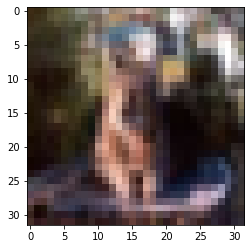

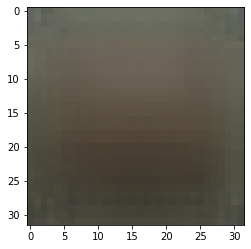

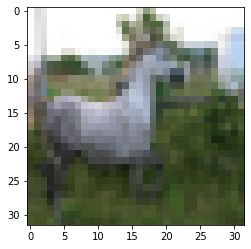

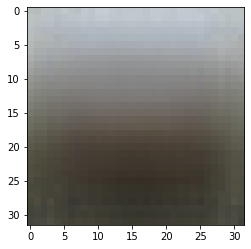

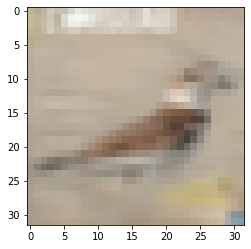

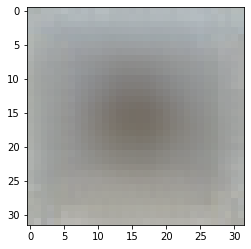

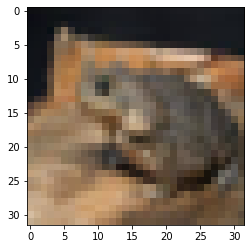

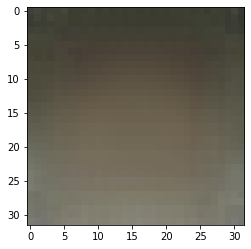

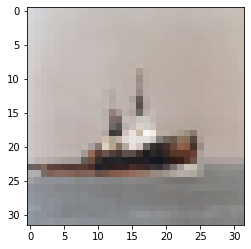

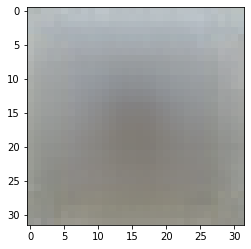

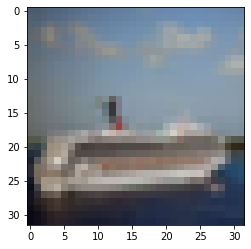

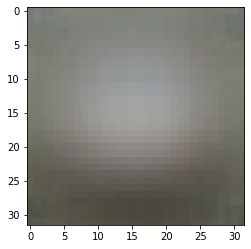

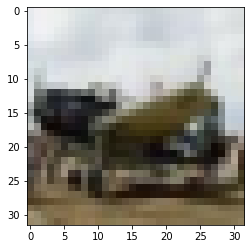

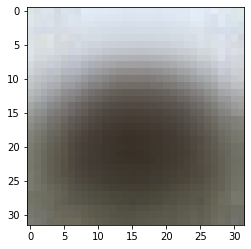

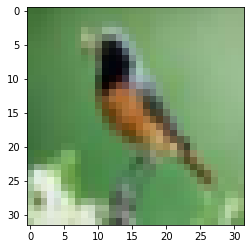

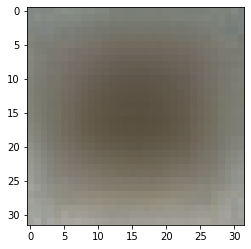

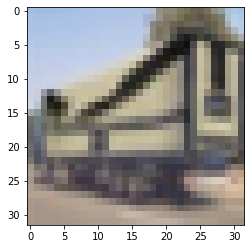

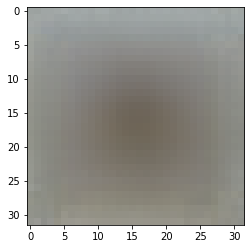

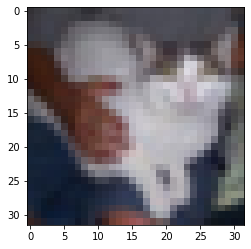

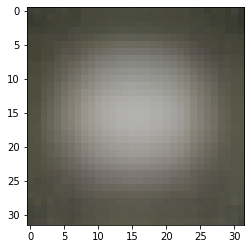

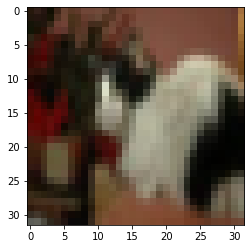

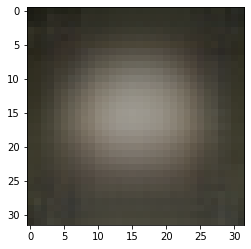

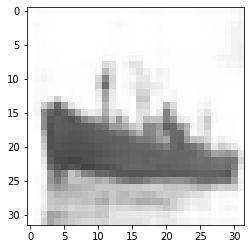

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


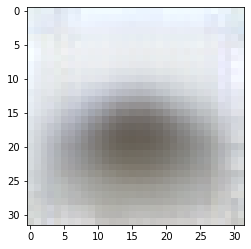

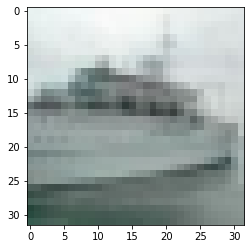

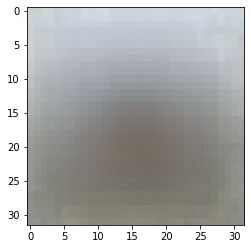

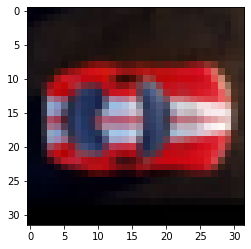

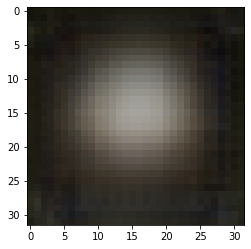

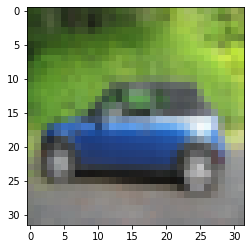

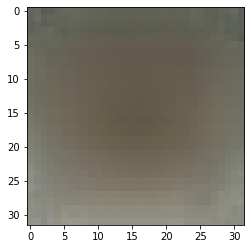

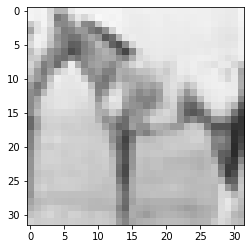

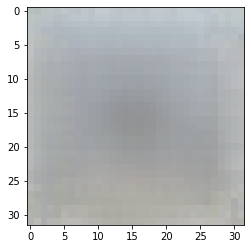

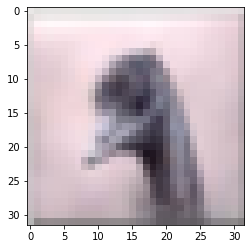

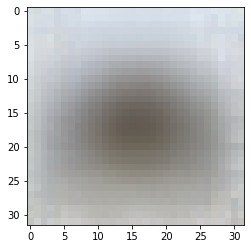

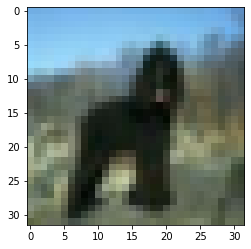

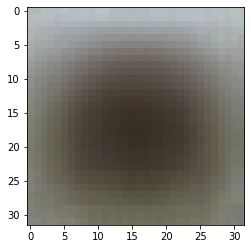

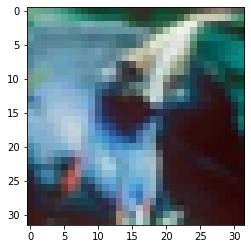

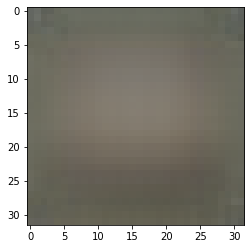

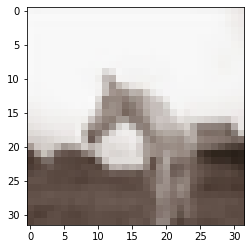

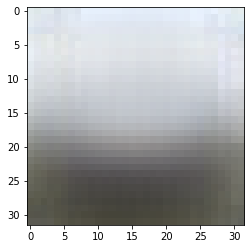

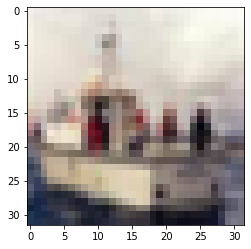

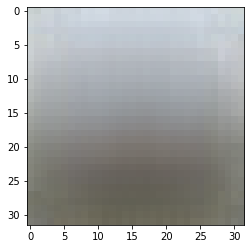

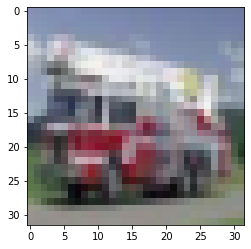

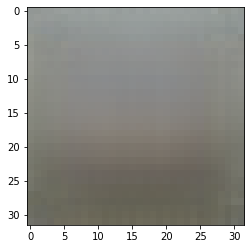

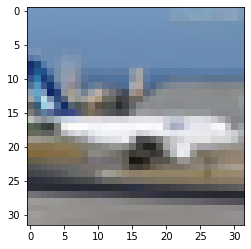

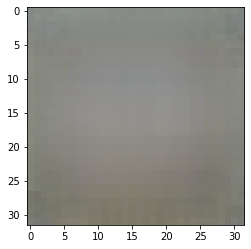

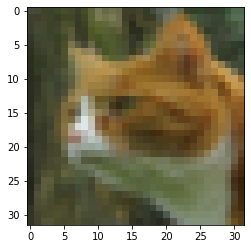

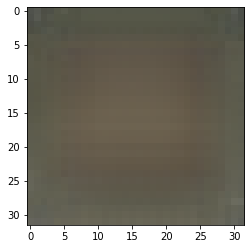

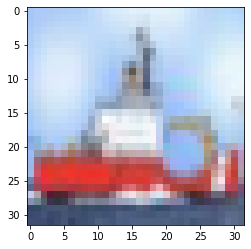

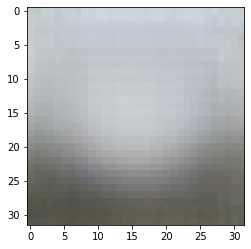

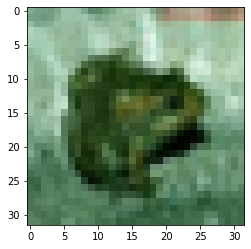

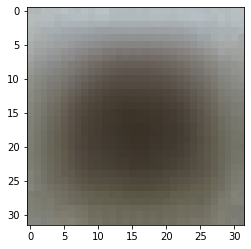

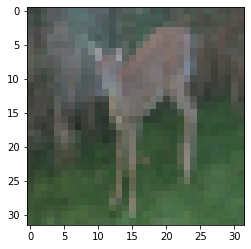

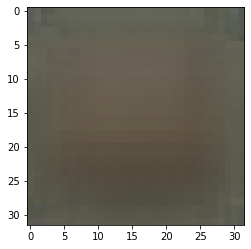

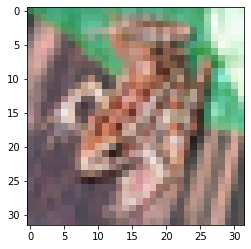

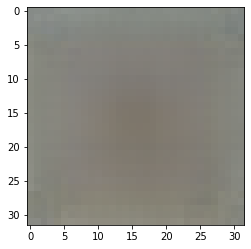

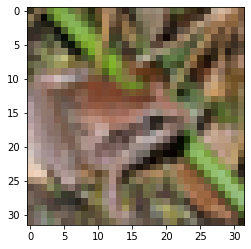

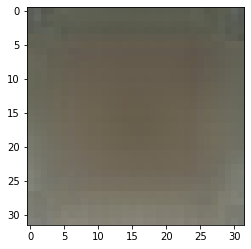

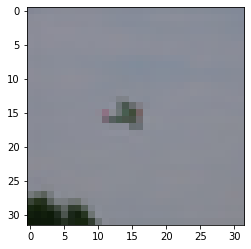

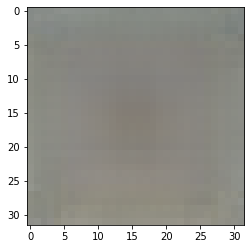

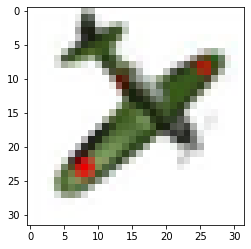

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


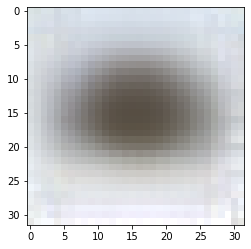

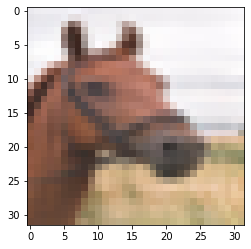

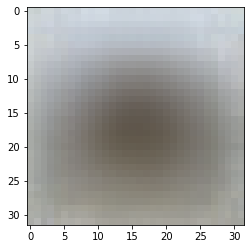

In [94]:
for index in range(100):
    imshow(test_input[index].cpu())
    imshow(compressed[index].detach().cpu())